In [67]:
#LIBRERIAS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from numpy import sin , cos , pi 
import time

## Subrutinas

**1) subrutina de rotacion**

Denotamos la posicion de la casa blanca antes de la rotacion como $\ \vec{r}_{wh0}\ $ y despues de la rotacion como $\ \vec{r}_{wh}\ $. 

La rotación del vector $\vec{r}_{wh0}$ un angulo $\lambda$ transcurrido un tiempo $\Delta t$ viene dada por:
$$
\vec{r}_{wh}=R_z(\lambda)\ \vec{r}_{wh0} 
$$
La anti-rotación viene dada por:
$$
\vec{r}_{wh0}=R_z(-\lambda)\ \vec{r}_{wh} 
$$

In [68]:
#Angulo theta
def rotacion(A,t):

  #Angulo de rotacion en funcion del tiempo
  theta = 7.2722052e-5*t

  # Matriz de anti-rotacion al rededor del eje z
  Rz=np.array([ [ cos(theta)    , -sin(theta) , 0 ],
                [ sin(theta)    ,  cos(theta) , 0 ],
                [     0         ,      0      , 1 ]  ])
  
  # Vector A despues de la rotacion
  Ar = Rz @ A

  return Ar

**2) Subrutinas Newton Raphson**

Esta subrutina nos ayuda a calcular la raiz de la funcion $F(z)$ que usaremos para calcular las funciones de Lagrange $f$, $g$, $f'$ y $g'$

In [69]:
#Metodo de Newton Raphson
def NR(zp,F,dF):
  zold=zp
  tol=1e-8
  dz=abs(2*tol)

  while dz > tol:
    znew=zold-F(zold)/dF(zold)
    dz=abs(znew-zold)
    zold=znew

  return zold

# Transformación de coordenadas
**Tenemos cuatro subrutinas para transformar coordenadas:**

El orden para introducir las coordenadas angulares es: **(Latitud,Longitud)** Siguiendo esta lógica, las coordenadas $\psi$,$\varphi$ corresponden a la latitud y la coordenada $\lambda$ a la longitud.

1) CT($\vec{r}$): **De cartesianas a geocentricas** $(x,y,z)\rightarrow (\psi,\lambda)$

2) TC($\psi,\lambda$) **De geocentricas a cartesianas** $(\psi,\lambda)\rightarrow (x,yz)$

3) CG($\vec{r}$) **De cartesianas a geodesicas** $(x,y,z)\rightarrow (\varphi,\lambda)$

4) GC($\varphi,\lambda$) **De geodesicas a cartesianas** $(\varphi,\lambda)\rightarrow (x,y,z)$

**1) Subrutina CT:** $(x,y,z) \rightarrow (\psi,\lambda)$

In [70]:
# Tomando la convensión de las coordenadas esfericas tenemos:

# En coordenadas geodésicas:
# Theta-2pi es la latitud -> psi      y   phi es la longitud -> lambda

# En el sistema ascención recta - declinación:
# delta es la latitud   y    alpha es la Longitud 

# La salida debe ser (latitud longitud) por lo tanto:
# En el sistema geodesico: (  psi , lambda )
# En el sistema A-D      : ( delta , alpha )
 
def CT(B):

  x=B[0] ; y=B[1] ; z=B[-1]

  if z > 0 :
	  theta = math.atan( math.sqrt( x**2 + y**2 ) / z )

  if z < 0 :
	  theta = pi + math.atan( math.sqrt( x**2 + y**2 ) / z )
   

  #Calculo de la longitud

  if x > 0 and y > 0 :
	  phi = math.atan( y / x )

  if x > 0  and y < 0 :
	  phi = 2*pi + math.atan( y / x )

  if  x < 0 :
	  phi = pi + math.atan( y / x )


  if phi >= 0 and phi <= pi :
	  long = phi

  if phi > pi and phi < 2*pi :
	  long = phi - 2*pi

  #Calculo de la latitud
  lat = 0.5*pi - theta

  return lat,long

**2) Subrutina TC:** $(\psi,\lambda) \rightarrow (x,y,z)$

In [71]:
def TC(psi,lam):
  Rt = 6.378
  lam=lam*pi/180 ; psi=psi*pi/180
  x  = Rt * cos(lam) * cos(psi)
  y  = Rt * sin(lam) * cos(psi)
  z  = Rt * sin(psi)
  vector = np.array([ x ,y ,z ])
  return vector 

**3) Subrutina CG: $(x,y,z)\rightarrow (\varphi,\lambda)$**

In [72]:
# La salida de esta funcion esta en grados " ° "
def CG(A):
  x=A[0] ; y=A[1] ; z=A[2]
  #Semi eje mayor y menor
  a=6.3781370 ; b=6.356752

  # -- Calculo de la longitud --
  
  # Primer cuadrante
  if x>0 and y>0: 
    longitud = math.atan( y / x )

  # Segundo y tercer cuadrante
  if x<0:
    longitud = math.atan( y / x ) + pi 

  # Cuarto cuadrante
  if x>0 and y<0:
    longitud = math.atan( y / x ) + 2*pi 

  phi = longitud

  if phi>=0 and phi<=pi:
	  longitud=phi

  if (phi>pi and phi<2*pi):
	  longitud=-2*pi+phi

  # -- Calculo de la latitud --

  e = (  1 - (b/a)**2  )**0.5
  eps = e**2 / ( 1 - e**2 ) 
  p = ( x**2 + y**2 )**0.5 ; q = math.atan(z*a/p/b)

  latitud = math.atan( (z+eps*b*sin(q)**3) / (p-e**2*a*cos(q)**3))

  # Subrutina que transforma coord's esfericas en terrestres

  latitud  = round( latitud*180/pi  , 6 )
  longitud = round( longitud*180/pi , 6 )

  return latitud, longitud

**4) Subrutina GC: $(\varphi,\lambda)\rightarrow (x,y,z)$**

In [73]:
# Los argumentos de esta funcion entran en grados " ° "
def GC(phi,lam):
  #Semi eje mayor y menor
  a=6.3781370 ; b=6.356752
  phi=phi*pi/180 ; lam=lam*pi/180

  N = a**2 / ( a**2 * cos(phi)**2 + b**2 * sin(phi)**2 )**0.5
  x = N * cos(lam) * cos(phi) 
  y = N * sin(lam) * cos(phi)
  z = N * (b/a)**2  * sin(phi)

  pos=np.array([ x , y , z ])

  return pos

**Función de aceleración**

La variable choicer nos indica el numero de aceleraciones agregadas a la total, vease la siguiente tabla:

Choicer | Numero de terminos de la aceleración 
----:|:------
 1 | $\vec{F}_g$
 2 | $\vec{F}_g+\vec{F}_p$
 3 | $\vec{F}_g+\vec{F}_p+ \vec{F}_r$
 4 | $\vec{F}_g+\vec{F}_p+ \vec{F}_r+\vec{F}_{cor}+\vec{F}_{cen}$

In [74]:
#DEFINIMOS LA FUNCION DE ACELERACION EN T=0.
def FG(r,rp,v,t,u,choicer):
  
  # Parametros importantes
  B=123         # taza de perdida de masa [ kg/s ]
  mshell=3500   # Masa de la estructura del cohete [ kg ]
  m0=8000       # Masa inicial del combustible [ kg ]
  mu=3.98e-4    # Parametro gravitatorio [ Mm³/kg/s² ]
  J2=1.08263e-3 # segundo armonico zonal
  a=6.378137    # Radio ecuatorial [ Mm ]

  # magnitud de los vetores de entrada
  nv = np.linalg.norm(v) # [ Mm ]
  nr = np.linalg.norm(r) # [ Mm/s ]

   # Longitud y latitud
  lamda=CT(r)[1] ; psi=CT(r)[0] # radianes

  #Vectores er y epsi  
  epsi = np.array([ -cos(lamda)*sin(psi), 
                    -sin(lamda)*sin(psi),
                     cos(psi)           ])
  
  er = np.array([cos(lamda)*cos(psi),
                 sin(lamda)*cos(psi),
                 sin(psi)               ])

  #Velocidad angular de la tierra
  w = np.array([ 0 , 0 , 7.2722052e-5 ]) # [ Rad/s ]

  #Velocidad del misil en el marco no inercial
  vr = np.cross(w,v) # [ Mm/s ]

  # vector  w x r 
  p = np.cross(w,r) # [ Mm/s ]

  # vector unitario en direccion del movimiento
  vu = ( rp - r ) / np.linalg.norm( rp - r ) 

  # Funcion de masa
  m = mshell + m0 - B*t #[ kg ]

  # Fuerza de propulsión
  Fr = B * u * vu /  m  # [ Mm/s² ]

  # Fuerza gravitacional central
  Fg = - mu / nr**2 * er # [ Mm/s² ]

  # Fuerza de perturbacion [ Mm/s² ]
  Fp = -1.5 * mu*J2*(a/nr**2)**2 * (1-3*sin(psi)**2)*er - 3*mu*J2*(a/nr**2)**2 *sin(psi)*cos(psi)*epsi 

  # Fuerza coriolis  
  Fcor = 2 * np.cross(vr,w)  # [ Mm/s² ]

  # Fuerza centrifuga
  Fcen = np.cross(w,p) # [ Mm/s² ]

  if choicer==1: # Aceleración kepleriana
    d2r = Fg 

  elif choicer==2: # Aceleración perturbada
    d2r = Fg + Fp 

  elif choicer==3: # Aceleración perturbada con empuje 
    d2r = Fg + Fp + Fr 
  
  elif choicer==4: # Aceleración no inercial perturbada con empuje  
    d2r = Fr + Fg + Fp - Fcor - Fcen
  
  return d2r

# Simulación 3 
##  Meteorito - Tierra Oblata 
Un meteorito se dirige a la tierra, sus condiciones iniciales son:
$$
\vec{r}_0=(\ 0.50000000,\ -6.5000000,\ 4.5000000\ ) \ [Mm]
$$
$$
\vec{v}_0=(\ 0.00129502,\ -0.00142576,\  0.00171175\ ) \ [Mm/s]
$$

In [75]:
# --------------------------- CONDICIONES INICIALES ----------------------------

#Posicion inicial del meteorito y su norma [ Mm ]
r0=np.array([0.50000,-6.50000,4.50000])  
nr0=np.linalg.norm(r0)

#Velocidad inicial del meteorito y su norma [ Mm/s ]
v0=np.array([0.00129502, -0.00142576,  0.00171175])
nv0=np.linalg.norm(v0)

# Tiempo de vuelo [segundos]
dt=1200
# ------------------------------------------------------------------------------

#Parametros de tierra oblata
a = 6.3781370 ; b = 6.356752 
mu = 3.98e-4  ; J2 = 1.08263e-3 

# ------------------------------------------------------------------------------

La ecuación de movimiento de un cuerpo que orbita una tierra oblata es

$$
\ddot{\vec{r}}=\Big[ -\frac{\mu}{r^2} +3\frac{\mu J_2 R^2}{r^4}\Big( \frac{3}{2}sin^2\psi-\frac{1}{2}\Big) \Big]\hat{e}_r+\Big[ -3\frac{\mu J_2 R^2}{r^4}sin\psi cos\psi\Big]\hat{e}_{\psi}
$$
Donde los vectores unitarios son:

$$
\hat{e}_r=
\begin{pmatrix}
  \ cos\lambda \cos\psi \\
  \ sin\lambda cos\psi \\
  \  sin\psi
\end{pmatrix}
\ \ \ \& \ \ \ \ 
\hat{e}_{\psi}
\begin{pmatrix}
  -cos\lambda sin\psi\ \\
  -sin\lambda sin\psi \\
  cos\psi
\end{pmatrix}
$$

**Solución de la ecuación de movimiento**

- Para Resolverla usaremos el RK4

- La condicion de parada sera cuando $|\vec{r}| \leq R$ donde $R$ es la distancia que hay entre el punto de impacto y el centro de la tierra, esta distancia viene dada por

$$
R = \frac{ab}{\sqrt{ a^2 cos^2\psi + b^2 sin^2\psi}}
$$

Con

- $a$ = Radio ecuatorial

- $b$ = Radio polar

In [76]:
#condiciones iniciales
r = r0   ; v = v0 ; dummy=np.zeros(3)
h = 0.01 ; t = 0 ; factor=180.0/pi

# Radio geodésico y geocéntrico
R = a*b / ( a**2*cos(CT(r)[0])**2 + b**2*sin(CT(r)[0])**2)**0.5 
nr=np.linalg.norm(r)

#Listas de coordenadas
Xmet = [ r0[0] ] 
Ymet = [ r0[1] ] 
Zmet = [ r0[2] ] 
tiempo = [ 0 ]

#Listas de velocidad y distancia
Vmet = [ np.linalg.norm(v0) ] 
Rmet = [ np.linalg.norm(r0) ]
N    = [ R ] 

#Distancia a la casa blanca
rwh0 = GC(38.897363, -77.036557)
wh = [ rwh0 ]
Error = [ np.linalg.norm( r0 - rwh0) ]

# Listas de la tabla 2.2
ALPHA=[CT(r0)[1]*factor] ; DELTA=[CT(r0)[0]*factor] ; LAMBDA=[CT(rwh0)[1]*factor] ; DIF=[np.linalg.norm(r0-rwh0)]

i=1
while t <= dt:
  t+=h
  l1 = h * FG(r,dummy,dummy,0,0,2)
  k1 = h * v
  l2 = h * FG(r+0.5*k1,dummy,dummy,0,0,2)
  k2 = h * ( v + 0.5 * l1 )
  l3 = h * FG(r+0.5*k2,dummy,dummy,0,0,2)
  k3 = h * ( v + 0.5 * l2 )
  l4 = h *  FG(r+k3,dummy,dummy,0,0,2)
  k4 = h * ( v + l3 )

  v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
  nv = np.linalg.norm( v )
  r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 ) 
  nr = np.linalg.norm( r ) 

  # Serie de tiempo r[met] tabla 2.2
  Rmet.append(nr)

  # Datos de la grafica 2.8
  rwh = rotacion(rwh0,t)
  error = np.linalg.norm( r - rwh )
  delta=CT(r)[0]*factor
  alpha=CT(r)[1]*factor
  lamda=CT(rwh)[1]*factor
  diferencia=np.linalg.norm(r-rwh)


  # Serie de tiempo N[met] tabla 2.2
  psi = CT(r)[0]
  R = a*b / ( a**2 * cos( psi )**2 + b**2 * sin( psi )**2 )**0.5
  N.append(R)

  Xmet.append(r[0]) ; Ymet.append(r[1]) ; Zmet.append(r[2]) 
  Vmet.append(nv)   ; Rmet.append(nr)   ; tiempo.append(t)
  Error.append(error) ; N.append(R) ; wh.append(rwh)
  ALPHA.append(alpha) ; DELTA.append(delta) ; LAMBDA.append(lamda)
  DIF.append(diferencia)

  if i%10000==0:
    print('t=',round(t,1),'|r|=',round(nr,4),'R=',round(R,4),'Error=',round(error,6))
  i+=1
print('_________________________________________________________________________________')
print()
print('rf=',r,'Mm')
print('r2=',rwh,'Mm/s')
print('d=',Error[-2]*1000,'Km')

t= 100.0 |r|= 8.1138 R= 6.3638 Error= 1.9738
t= 200.0 |r|= 8.2475 R= 6.3639 Error= 2.064545
t= 300.0 |r|= 8.3245 R= 6.364 Error= 2.108754
t= 400.0 |r|= 8.3459 R= 6.3641 Error= 2.103976
t= 500.0 |r|= 8.3119 R= 6.3642 Error= 2.048341
t= 600.0 |r|= 8.2221 R= 6.3643 Error= 1.939994
t= 700.0 |r|= 8.0753 R= 6.3645 Error= 1.77675
t= 800.0 |r|= 7.8694 R= 6.3646 Error= 1.555826
t= 900.0 |r|= 7.6012 R= 6.3647 Error= 1.27356
t= 1000.0 |r|= 7.2665 R= 6.3648 Error= 0.925056
t= 1100.0 |r|= 6.8589 R= 6.3649 Error= 0.503644
t= 1200.0 |r|= 6.3698 R= 6.3651 Error= 1.9e-05
_________________________________________________________________________________

rf= [ 1.53293856 -4.72815227  3.98344048] Mm
r2= [ 1.53295288 -4.72819493  3.98345534] Mm/s
d= 0.019435338500901966 Km


In [77]:
len(Xmet)

120002

In [78]:
print('Punto de impacto rotado:')
coordenadas2 = CG(r)
print(coordenadas2)
print()
print('Punto de impacto real:')
r_ = rotacion(r,-round(t))
coordenadas = CG(r_)
coordenadas

Punto de impacto rotado:
(38.897513, -72.036521)

Punto de impacto real:


(38.897513, -77.036521)

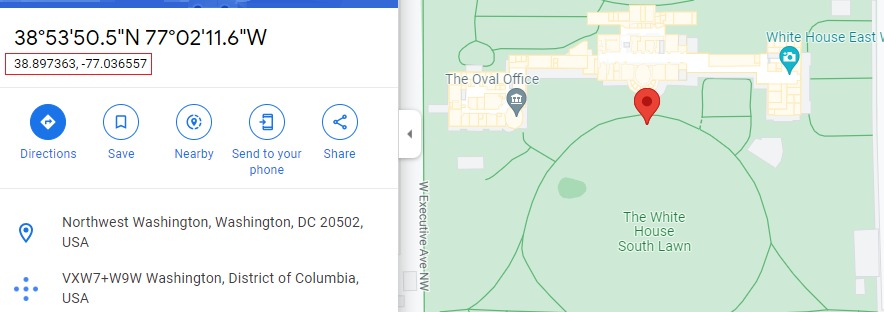

**Tabla 2.2 de mi tesis**

In [12]:
print('t  delta(°)   alpha(°)   r[Mm]     N[Mm]    lambda(°) d(r,rwh)')
for i in range(0,len(Xmet)):
  vector = np.array([ Xmet[i] , Ymet[i] , Zmet[i] ])
  nvector = np.linalg.norm(vector)
  if i%24000==0 and i!=len(Xmet):
    print(int(i/6000),round(ALPHA[i],6),round(DELTA[i],6),round(nvector,7),round(N[i],6),round(LAMBDA[i],6),round(DIF[i],7))


t  delta(°)   alpha(°)   r[Mm]     N[Mm]    lambda(°) d(r,rwh)
0 -85.601295 34.616096 7.9214898 6.36363 -77.036557 1.8406641
4 -83.208513 35.489614 8.2850362 6.363788 -76.036557 2.0879728
8 -80.882665 36.274451 8.3231732 6.363936 -75.036557 2.0636222
12 -78.438441 37.032855 8.0389178 6.364077 -74.036557 1.7372825
16 -75.6394 37.820105 7.408727 6.364213 -73.036557 1.0727855
20 -72.036699 38.709528 6.3697569 6.364348 -72.036557 1.94e-05


**Figura 2.8 de mi tesis**

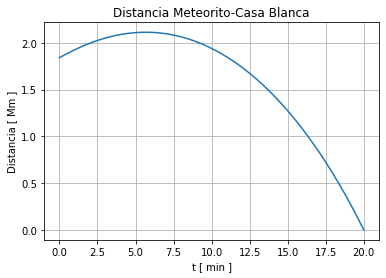

In [13]:
time=[tiempo[i]/60 for i in range(len(tiempo))]
plt.plot(time,DIF)
plt.title('Distancia Meteorito-Casa Blanca')
plt.xlabel('t [ min ]')
plt.ylabel('Distancia [ Mm ]')
plt.grid()
plt.savefig('graph6.png', dpi=250)
plt.show()

**Guardamos las coordenadas de la trayectoria del meteorito en un archivo .csv**

In [79]:
## ---- COORDENADAS DEL METEORITO -----

##Creamos una lista de listas
coordenadas_meteorito = {'t':tiempo,'Xmeteorito':Xmet,'Ymeteorito':Ymet,'Zmeteorito':Zmet}

#Creamos un dataframe
df_meteorito = pd.DataFrame(coordenadas_meteorito)

#Creamos un archivo csv de los datos obtenidos
file = open('coordsmetpert.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
df_meteorito.to_csv('coordsmetpert.dat', sep =' ', index = False, header=False)

**Así luce la trayectoria del meteorito**

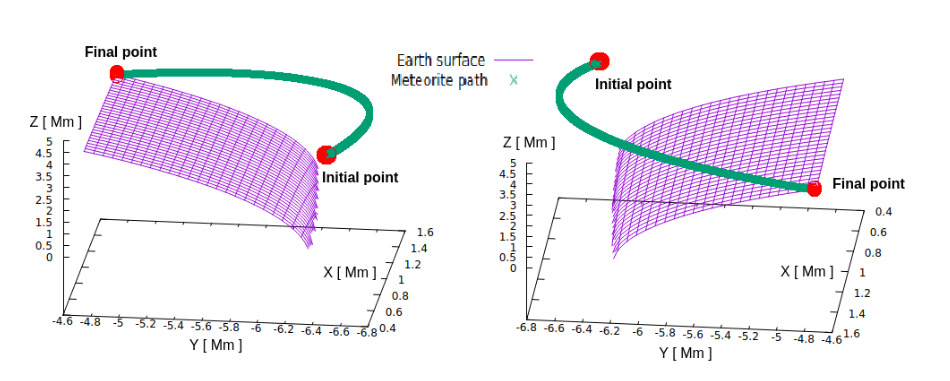

# Simulación 4
## Persecución misil-meteorito (problema perturbado)

**Las condiciones iniciales del lanzamiento del misil son:**


In [80]:
#Posicion inicial del misil (University of Toronto)
r0  = TC( 43.662977 , -79.397759 )  
nr0=np.linalg.norm(r0)

#Punto objetivo
rp = np.array([ Xmet[int(500/h)] , Ymet[int(500/h)], Zmet[int(500/h)]])

#Distancia relativa entre el misil y el punto objetivo (t=0)
d0 = np.linalg.norm(rp-r0)

# Parametros iniciales del misil
u=0.010 # Rapidez inicial [ Mm/s ]
B  = 123 # Razon de perdida de masa [ kg/s ]
m0 = 8000 # Masa inicial del combustible [ kg ]

#Velocidad inicial del misil
v0 = u*( rp - r0 ) / d0 # [ Mm/s ]
nv0=np.linalg.norm(v0) # [ Mm/s ]

print('r0=',r0)
print('v0=',v0)

r0= [ 0.84891619 -4.5351625   4.40346754]
v0= [ 0.00109184 -0.00963935  0.00242708]


## Solución de la ecuación de movimiento

La ecuación de movimiento se soluciona usando el algorimo Runge Kutta de orden 4.

**Solución de la etapa de despegue**


In [81]:
#Tiempo de propulsion
tp = m0 / B
h = 0.01

#Listas de coordenadas
Xm=[ r0[0] ] ; Ym=[ r0[1] ] ; Zm=[ r0[2] ] 
Vx=[ v0[0] ] ; Vy=[ v0[1] ] ; Vz=[ v0[2] ] 
tiempo=[0] ; V=[nv0] ; R=[nr0]

#--------------- Despegue ------------------
v = v0 ; r = r0 ; t=h
v = v + FG(r0,rp,v0,t,u,4)  
r = r + v 

Xm.append(r[0])  ;  Vx.append(v[0])
Ym.append(r[1])  ;  Vy.append(v[1])
Zm.append(r[2])  ;  Vz.append(v[2])
tiempo.append(t);  V.append( np.linalg.norm(v) ) ; R.append( np.linalg.norm(r))

# -----------------------------------------

**Etapa de vuelo propulsado**

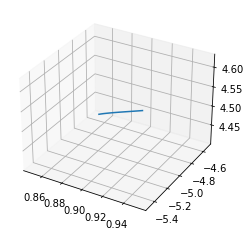

In [82]:
# -------------- Vuelo propulsado -----------------

t=2*h
while t <= tp:
  t+=h
  l1 = h * FG(r,rp,v,t,u,3)
  k1 = h * v
  l2 = h * FG(r+0.5*k1,rp,v+0.5*l1,t+0.5*h,u,3)
  k2 = h * ( v + 0.5 * l1 )
  l3 = h * FG(r+0.5*k2,rp,v+0.5*l2,t+0.5*h,u,3)
  k3 = h * ( v + 0.5 * l2 )
  l4 = h *  FG(r+k3,rp,v+l3,t+h,u,3)
  k4 = h * ( v + l3 )

  v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
  vel= np.linalg.norm(v)
  r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 )
  desplazamiento = np.linalg.norm(r)

  Xm.append(r[0])  ;  Vx.append(v[0])
  Ym.append(r[1])  ;  Vy.append(v[1])
  Zm.append(r[2])  ;  Vz.append(v[2])
  tiempo.append(t)
  V.append( vel )  
  R.append( desplazamiento )

#---------------- Graficos ----------------------

# Creamos la figura
fig = plt.figure()

# Agrrgamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')

# Datos en array bi-dimensional
x = np.array([Xm])
y = np.array([Ym])
z = np.array([Zm])

# plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
# Es necesario que los datos esten contenidos en un array bi-dimensional
ax1.plot_wireframe(x, y, z)

# Mostramos el gráfico
plt.show()

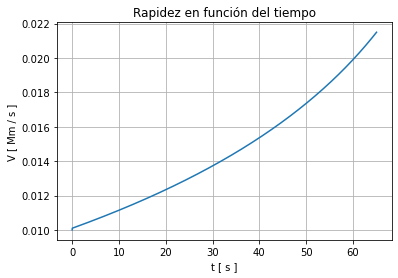

Rapidez inicial:  0.01 Mm/s
Rapidez final  :  0.021497266133701804 Mm/s
------------------------------


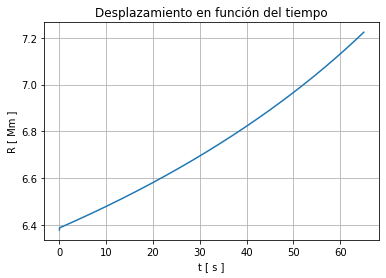

R inicial:  6.378 Mm
R final  :  7.224258734148426 Mm


In [18]:
# Rapidez vs tiempo
plt.plot(tiempo,V)
plt.title('Rapidez en función del tiempo')
plt.xlabel('t [ s ]')
plt.ylabel('V [ Mm / s ]')
plt.grid()
plt.savefig('vel.png', dpi=250)
plt.show()

print('Rapidez inicial: ',V[0],'Mm/s')
print('Rapidez final  : ',V[-1],'Mm/s')
print('------------------------------')

# Desplazamiento vs tiempo
plt.plot(tiempo,R)
plt.title('Desplazamiento en función del tiempo')
plt.xlabel('t [ s ]')
plt.ylabel('R [ Mm ]')
plt.grid()
plt.savefig('desp.png', dpi=250)
plt.show()

print('R inicial: ',R[0],'Mm')
print('R final  : ',R[-1],'Mm')

In [83]:
print('Vector de estado final:')
print('rf=',r,'Mm')
print('vf=',v,'Mm/s')

Vector de estado final:
rf= [ 0.95323208 -5.46463143  4.6280737 ] Mm
vf= [ 0.00232873 -0.02078068  0.00498725] Mm/s


## Etapa de vuelo libre
En esta etapa la ecuación de movimiento es
$$
\ddot{\vec{r}}=-\frac{\mu}{r^3}\vec{r}+\vec{F}_p
$$
y las condiciones iniciales es el vector de estado obtenido anteriormente.

## Problema de Lambert
Para resolver el problema de lambert establecemos $\vec{r}_2$ como $\vec{r}_{met}(t=500s)$. 

Hecho ésto tenemos que el tiempo de vuelo es 
$$
\tau=\Delta t - t'\ \rightarrow\  \tau=500-65\ \rightarrow\ \tau=435\ seg.
$$

In [84]:
#Estado final del vuelo propulsado:
r0 = r   ;  nr0 = np.linalg.norm(r0)   
v0 = v   ;  nv0 = np.linalg.norm(v0)

#Posicion inicial del misil
r1=r0 ; v0old=v0

#Se elige el punto de impacto como la posicion del meteorito en t=500
indice=int(500/h)
r2=np.array([ Xmet[indice] , Ymet[indice] , Zmet[indice] ])

# TIEMPO DE VUELO: 
# el tiempo que le toma al meteorito llegar a ese punto menos lo que ya transcurrió el misil
tau=500-tp

#Constante mu [ Mm³/kg/s² ]
mu=3.98e-4 

print('r1=',r1,'Mm')
print('r2=',r2,'Mm')
print('v0=',v0,'Mm/s')
print('tv=',round(tau,6),'segundos')


r1= [ 0.95323208 -5.46463143  4.6280737 ] Mm
r2= [ 1.08362527 -6.60729625  4.92520716] Mm
v0= [ 0.00232873 -0.02078068  0.00498725] Mm/s
tv= 434.95935 segundos


**Algoritmo (1.7.2) de mi tesis**

Este algoritmo sirve para calcular la $\vec{v}_1$, el $\Delta \vec{v}$ y la perdida de masa.

In [85]:
# 1) calculamos r1 y r2
nr1=np.linalg.norm(r1)
nr2=np.linalg.norm(r2)

# 2) Calculamos delta theta
k  = np.array([0,0,1])
r3 = np.cross(r1,r2)
rz = r3 @ k

if rz < 0:
  dtheta = math.acos( r1 @ r2 / ( nr1 * nr2 ))
else:
  dtheta = 2*np.pi-math.acos( r1 @ r2 / ( nr1 * nr2 ) )

# 3) Calculamos A
A = np.sin(dtheta)*math.sqrt( nr1 * nr2 / (1-np.cos(dtheta)))

# 4) Definimos las funciones S(z), C(z), S'(z), C'(z), y(z), y'(z), F(z) y F'(z)

# Funcion S(z)
def S(x): 
  y=0
  for n in range(8):
    y+=(-1)**n*x**n/math.factorial(2*n+3)
  return y

#Funcion S'(z)
def dS(x):
  y=0
  for n in range(8):
    y+=(-1)**(n+1) * ( n + 1 ) * x**n /math.factorial(2*n+5)
  return y

# Funcion C(z)
def C(x):
  y=0
  for n in range(8):
    y+=(-1)**n * x**n /math.factorial(2*n+2)
  return y 

# Funcion C'(z)
def dC(x):
  y=0
  for n in range(8):
    y+=(-1)**(n+1)*(n+1)*x**n/math.factorial(2*n+4) 
  return y

y = lambda x: nr1 + nr2 + A * ( x*S(x) - 1 ) / C(x)**0.5

dy = lambda x: A/4*C(x)**0.5 

F  = lambda x: (y(x)/C(x))**1.5 *  S(x) + A*y(x)**0.5 - mu**0.5 * tau

dF = lambda x: 0.5/(y(x)*C(x)**5)**(0.5) * ( (2*C(x)*dS(x) - 3*dC(x)*S(x))*y(x)**2 + (A*C(x)**2.5+3*C(x)*S(x)*y(x))*dy(x)  ) 

#Metodo de Newton Raphson
zr=NR(1,F,dF)

# 6) Usamos el valor de z para evaluar las funciones f, g y dg
yz=y(zr)
f=1-yz/nr1
g=A*(yz/mu)**0.5
dg=1-yz/nr2 

# Calculamos la velocidad inicial
v1=1/g*(r2-f*r1)

print('La velocidad inicial que cumple el problema de Lambert es:')
print('v1=',v1,'Mm/s')
print()
print('La maniobra requirio el siguiente dv:')
Vec_dv=v1-v0
dv=np.linalg.norm(v1-v0old)
print('dv=',Vec_dv,'Mm/s')
print()
print('Cuya magnitud es:')
print('|dv|=',dv*1000,'km/s')

grav=mu/8.31489**2
MassRate=1-math.exp(-0.001/grav/455)
MassRate
  
print()
print('la porcion de masa empleada en la maniobra fue:')
print(MassRate/0.01,'% de la masa actual')
print()
print('Incremento porcentual en la rapidez del misil:')
print(dv/np.linalg.norm(v0)*100)

La velocidad inicial que cumple el problema de Lambert es:
v1= [ 0.00049316 -0.00375944  0.00160175] Mm/s

La maniobra requirio el siguiente dv:
dv= [-0.00183557  0.01702124 -0.0033855 ] Mm/s

Cuya magnitud es:
|dv|= 17.45146600444169 km/s

la porcion de masa empleada en la maniobra fue:
31.735800633557677 % de la masa actual

Incremento porcentual en la rapidez del misil:
81.17993188483904


## Maniobra orbital
Al aplicar la mabiobra tenemos que:
$$
\vec{v}_1=\vec{v}_0+\Delta \vec{v}
$$

In [86]:
print('Las condiciones iniciales son entonces:')
print('r1=',r1,'Mm')
print('v1=',v1,'Mm/s')

Las condiciones iniciales son entonces:
r1= [ 0.95323208 -5.46463143  4.6280737 ] Mm
v1= [ 0.00049316 -0.00375944  0.00160175] Mm/s


**La ecuación de movimiento a resolver ahora es**
$$
\ddot{\vec{r}}=-\frac{\mu}{r^3}\vec{r}+\vec{F}_p
$$
Y las condiciones iniciales son $\vec{r}_1$ y $\vec{v}_1$

In [87]:
# Parametros iniciales
r=r1 ; v=v1 ; 
t=0 

i=1
while t <= tau:
  t+=h 
  l1 = h * FG(r,rp,v,0,0,2)
  k1 = h * v
  l2 = h * FG(r+0.5*k1,rp,v,0,0,2)
  k2 = h * ( v + 0.5 * l1 )
  l3 = h * FG(r+0.5*k2,rp,v,0,0,2)
  k3 = h * ( v + 0.5 * l2 )
  l4 = h *  FG(r+k3,rp,v,0,0,2)
  k4 = h * ( v + l3 )
  v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
  r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 )

  # Error en el punto de impacto ~ epi
  epi = np.linalg.norm(r2-r)

  if i%5000==0:
    print('t=',round(t,5),'s','Error=',round(epi*1000,5),'Km')
  i+=1
print('--------------------------------------------------')
print()
print('Error en el punto de impacto:',round(epi*1000,8),'Km')

t= 50.0 s Error= 993.08501 Km
t= 100.0 s Error= 815.26972 Km
t= 150.0 s Error= 653.48703 Km
t= 200.0 s Error= 506.91362 Km
t= 250.0 s Error= 374.78595 Km
t= 300.0 s Error= 256.37299 Km
t= 350.0 s Error= 150.94796 Km
t= 400.0 s Error= 57.75696 Km
--------------------------------------------------

Error en el punto de impacto: 0.70765106 Km


**707 metros de error** 

Apliquemos el algoritmo ASR!

In [27]:
# Fijamos la semilla para poder reproducir los mismos resultados en el futuro
np.random.seed(150)

#Tiempo inicial 
start = time.time()

# Error 
error = epi ; v0=v1
 
while error > 5e-6:

  if r[0] > r2[0]:
    vxrand=-np.random.rand()*1e-7
  elif r[0] < r2[0]:
    vxrand=np.random.rand()*1e-7

  if r[1] > r2[1]:
    vyrand=-np.random.rand()*1e-7
  elif r[1] < r2[1]:
    vyrand=np.random.rand()*1e-7

  if r[2] > r2[2]:
    vzrand=-np.random.rand()*1e-7
  elif r[2] < r2[2]:
    vzrand=np.random.rand()*1e-7

  v0old=v0

  # Cambio de velocidad aleatorio
  dvrand = np.array([ vxrand, vyrand, vzrand ])
  v0= v0 + dvrand 

  # Condiciones iniciales
  r=r1 ; v=v0 ; t=0

  # ------------------------------------------

  while t <= tau:
    l1 = h * FG(r,rp,v,0,0,2)
    k1 = h * v
    l2 = h * FG(r+0.5*k1,rp,v,0,0,2)
    k2 = h * ( v + 0.5 * l1 )
    l3 = h * FG(r+0.5*k2,rp,v,0,0,2)
    k3 = h * ( v + 0.5 * l2 )
    l4 = h *  FG(r+k3,rp,v,0,0,2)
    k4 = h * ( v + l3 )
    v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
    r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 )
    t+=h 

  Error = np.linalg.norm(r-r2)
  print('Error_new=',round(Error*1e3,6),'km ---','error_old=',round(error*1e3,7),'km')
  if Error < error:
    error = Error
    print('--------------------------------------------------------------------')
    print('Felicidades, rediciste el error!')
    print('v0=',v0*1000,'km/s','Error=',round(Error*1e6,8),'metros','rf=',r,'Mm')
    print('--------------------------------------------------------------------')

  else:
    continue

# Tiempo final
end = time.time()

# tiempo de computo
tc = end - start 

print('El tiempo de computo empleado por el algoritmo fue:',tc/60,'Minutos')

Error_new= 0.671664 km --- error_old= 0.7076511 km
--------------------------------------------------------------------
Felicidades, rediciste el error!
v0= [ 0.49306704 -3.7594134   1.60184184] km/s Error= 671.66377193 metros rf= [ 1.08367727 -6.60781495  4.92478363] Mm
--------------------------------------------------------------------
Error_new= 0.632977 km --- error_old= 0.6716638 km
--------------------------------------------------------------------
Felicidades, rediciste el error!
v0= [ 0.49299314 -3.75934359  1.60189356] km/s Error= 632.97671521 metros rf= [ 1.08364581 -6.60778452  4.92480489] Mm
--------------------------------------------------------------------
Error_new= 0.600946 km --- error_old= 0.6329767 km
--------------------------------------------------------------------
Felicidades, rediciste el error!
v0= [ 0.49289793 -3.75925223  1.60190138] km/s Error= 600.94552689 metros rf= [ 1.08360511 -6.60774374  4.92480656] Mm
----------------------------------------------

Error_new= 0.028732 km --- error_old= 0.0161676 km
Error_new= 0.029557 km --- error_old= 0.0161676 km
Error_new= 0.016409 km --- error_old= 0.0161676 km
Error_new= 0.026743 km --- error_old= 0.0161676 km
Error_new= 0.017476 km --- error_old= 0.0161676 km
Error_new= 0.012942 km --- error_old= 0.0161676 km
--------------------------------------------------------------------
Felicidades, rediciste el error!
v0= [ 0.49291847 -3.75821319  1.60286482] km/s Error= 12.94159777 metros rf= [ 1.08361289 -6.60729789  4.92521058] Mm
--------------------------------------------------------------------
Error_new= 0.044189 km --- error_old= 0.0129416 km
Error_new= 0.022782 km --- error_old= 0.0129416 km
Error_new= 0.030262 km --- error_old= 0.0129416 km
Error_new= 0.029063 km --- error_old= 0.0129416 km
Error_new= 0.038916 km --- error_old= 0.0129416 km
Error_new= 0.027103 km --- error_old= 0.0129416 km
Error_new= 0.025048 km --- error_old= 0.0129416 km
Error_new= 0.042614 km --- error_old= 0.0129416 

Error_new= 0.026068 km --- error_old= 0.0059721 km
Error_new= 0.0517 km --- error_old= 0.0059721 km
Error_new= 0.037149 km --- error_old= 0.0059721 km
Error_new= 0.04595 km --- error_old= 0.0059721 km
Error_new= 0.030172 km --- error_old= 0.0059721 km
Error_new= 0.030737 km --- error_old= 0.0059721 km
Error_new= 0.024032 km --- error_old= 0.0059721 km
Error_new= 0.022999 km --- error_old= 0.0059721 km
Error_new= 0.046695 km --- error_old= 0.0059721 km
Error_new= 0.029145 km --- error_old= 0.0059721 km
Error_new= 0.016253 km --- error_old= 0.0059721 km
Error_new= 0.019174 km --- error_old= 0.0059721 km
Error_new= 0.016823 km --- error_old= 0.0059721 km
Error_new= 0.038911 km --- error_old= 0.0059721 km
Error_new= 0.02944 km --- error_old= 0.0059721 km
Error_new= 0.008698 km --- error_old= 0.0059721 km
Error_new= 0.037412 km --- error_old= 0.0059721 km
Error_new= 0.008084 km --- error_old= 0.0059721 km
Error_new= 0.018467 km --- error_old= 0.0059721 km
Error_new= 0.031522 km --- error_ol

Error_new= 0.036087 km --- error_old= 0.0059721 km
Error_new= 0.026109 km --- error_old= 0.0059721 km
Error_new= 0.028065 km --- error_old= 0.0059721 km
Error_new= 0.012236 km --- error_old= 0.0059721 km
Error_new= 0.018808 km --- error_old= 0.0059721 km
Error_new= 0.026228 km --- error_old= 0.0059721 km
Error_new= 0.021496 km --- error_old= 0.0059721 km
Error_new= 0.03115 km --- error_old= 0.0059721 km
Error_new= 0.034129 km --- error_old= 0.0059721 km
Error_new= 0.043034 km --- error_old= 0.0059721 km
Error_new= 0.053221 km --- error_old= 0.0059721 km
Error_new= 0.036675 km --- error_old= 0.0059721 km
Error_new= 0.044579 km --- error_old= 0.0059721 km
Error_new= 0.018897 km --- error_old= 0.0059721 km
Error_new= 0.022165 km --- error_old= 0.0059721 km
Error_new= 0.031623 km --- error_old= 0.0059721 km
Error_new= 0.024182 km --- error_old= 0.0059721 km
Error_new= 0.043748 km --- error_old= 0.0059721 km
Error_new= 0.035611 km --- error_old= 0.0059721 km
Error_new= 0.036225 km --- error

In [47]:
print('El tiempo de computo fueron',np.floor(tc/3600),'Horas con',round((-np.floor(tc/3600)+tc/3600)*60,0),'minutos')

El tiempo de computo fueron 16.0 Horas con 59.0 minutos


In [88]:
#Llenamos las listas con el estado inicial del misil
r=r0 ; v=np.array([0.49294802, -3.75820538,  1.60285804])*1e-3 ; h=0.01 ; t=0

  # ------------------------------------------

while t <= tau:
    t+=h 
    l1 = h * FG(r,dummy,dummy,0,0,2)
    k1 = h * v
    l2 = h * FG(r+0.5*k1,dummy,dummy,0,0,2)
    k2 = h * ( v + 0.5 * l1 )
    l3 = h * FG(r+0.5*k2,dummy,dummy,0,0,2)
    k3 = h * ( v + 0.5 * l2 )
    l4 = h *  FG(r+k3,dummy,dummy,0,0,2)
    k4 = h * ( v + l3 )

    v = v + 1.0/6.0 * ( l1 + 2*l2 + 2*l3 + l4 )
    vel= np.linalg.norm(v)
    r = r + 1.0/6.0 * ( k1 + 2*k2 + 2*k3 + k4 )
    Radio = np.linalg.norm(r)

    Xm.append(r[0])  ;  Vx.append(v[0])
    Ym.append(r[1])  ;  Vy.append(v[1])
    Zm.append(r[2])  ;  Vz.append(v[2])
    tiempo.append(t+dt)
    V.append( vel )  
    #R.append(Radio)

d=np.linalg.norm(r-r2)
print('Punto de impacto:')
print('rimp=',r)
print('objetivo=',r2)
print('Tiempo=',t) 
print('Error=',d*1000000,'Metros')

Punto de impacto:
rimp= [ 1.08362539 -6.60729441  4.92520757]
objetivo= [ 1.08362527 -6.60729625  4.92520716]
Tiempo= 434.9599999997494
Error= 1.890642700826768 Metros


In [62]:
##Creamos una lista de listas
coordenadas_misil = {'Xmisil':Xm,'Ymisil':Ym,'Zmisil':Zm}

#Creamos un dataframe
df_misil = pd.DataFrame(coordenadas_misil)

#Creamos un archivo csv de los datos obtenidos
file = open('CoordsMisil.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
df_misil.to_csv('CoordsMisil.dat', sep =' ', index = False)

In [90]:
tamaño = len( Xm ) # Numero de puntos de la coordenada x del misil
#tamaño2 = len( Xmet ) # Numero de puntos de la coordenada x del meteorito
# tamaño deberia ser menor que tamaño 2 porque su tiempo de vuelo fue menor
Xmeteorito=[] ; Ymeteorito=[] ; Zmeteorito=[]

for i in range(tamaño):
  Xmeteorito.append( Xmet[i] )  
  Ymeteorito.append( Ymet[i] )
  Zmeteorito.append( Zmet[i] )


In [65]:
##Creamos una lista de listas
coordenadas_meteorito = {'Xmeteorito':Xmeteorito,'Ymeteorito':Ymeteorito,'Zmeteorito':Zmeteorito}

#Creamos un dataframe
df_meteorito = pd.DataFrame(coordenadas_meteorito)

#Creamos un archivo csv de los datos obtenidos
file = open('Meteoritoo.dat',"x")

#Escribimos los datos obtenidos en el archivo creado
df_meteorito.to_csv('Meteoritoo.dat', sep =' ', index = False)

In [66]:
df_meteorito

,Xmeteorito,Ymeteorito,Zmeteorito
0,0.500000,-6.500000,4.500000
1,0.500013,-6.500014,4.500017
2,0.500026,-6.500029,4.500034
3,0.500039,-6.500043,4.500051
4,0.500052,-6.500057,4.500068
...,...,...,...
119997,1.532934,-4.728341,3.983560
119998,1.532935,-4.728294,3.983530
119999,1.532937,-4.728246,3.983500
120000,1.532938,-4.728199,3.983470


In [63]:
df_misil

,Xmisil,Ymisil,Zmisil
0,0.848916,-4.535163,4.403468
1,0.850018,-4.544898,4.405914
2,0.850029,-4.544995,4.405938
3,0.850040,-4.545093,4.405963
4,0.850051,-4.545190,4.405987
...,...,...,...
530000,1.083620,-6.607231,4.925213
530001,1.083622,-6.607247,4.925212
530002,1.083623,-6.607263,4.925210
530003,1.083624,-6.607279,4.925209


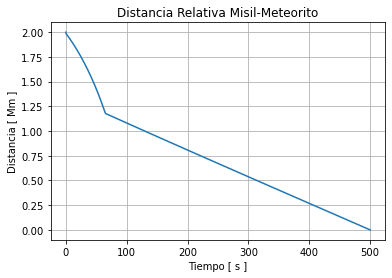

Distancia minima= 1.890642700826768 metros


In [91]:
Dx=np.array(Xmeteorito)-np.array(Xm)  
Dy=np.array(Ymeteorito)-np.array(Ym)  
Dz=np.array(Zmeteorito)-np.array(Zm)
D=(Dx**2+Dy**2+Dz**2)**0.5 
time=np.linspace(0,500,len(D))
plt.plot(time,D)
plt.title('Distancia Relativa Misil-Meteorito')
plt.ylabel('Distancia [ Mm ]')
plt.xlabel('Tiempo [ s ]')
plt.grid()
plt.savefig('grafdist2.png', dpi=250)
plt.show()

#Rmisil=np.array([Xmisil[500],Ymisil[500],Zmisil[500]]) ; Rmeteorito=np.array([Xmeteorito[500],Ymeteorito[500],Zmeteorito[500]])
#Rmisil,Rmeteorito
print('Distancia minima=',D.min()*1e6,'metros')

**Las trayectorias de ambos proyectiles lucen así**:

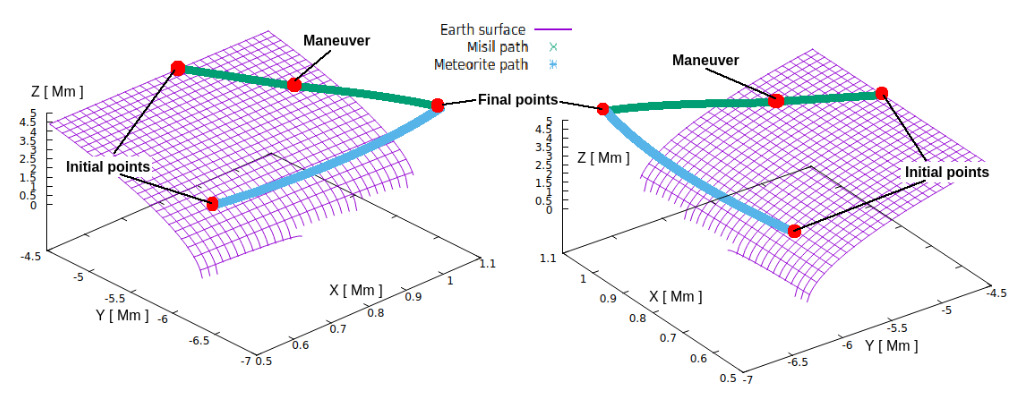

La simulación fue todo un exito!

Gracias por llegar hasta el final :)